# Design and Implementation Choices of the Model
## Import Libraries and Load Datasets

In [382]:
# Importing Libraries
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
from scipy import stats
import itertools
import tensorflow as tf
import keras

# Modelling Helpers :
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score, StratifiedKFold

# Performance metrics
from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score, precision_score, f1_score, recall_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#preprocessing :
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler

# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from keras import regularizers
from keras.layers import Dense, BatchNormalization, Dropout, Conv2D, Input,Activation, ZeroPadding2D, MaxPooling2D, Flatten, merge
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1, l2
from keras.layers import LSTM

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [2]:
#Load covid_train dataset
df_covid = pd.read_csv('COVID_dataset.csv') 
df_covid.head()

Accurate_Episode_Date Case_Reported_Date Test_Reported_Date Specimen_Date  \
0            2020-03-30         2020-03-31         2020-03-31    2020-03-30   
1            2021-01-22         2021-01-24         2021-01-24    2021-01-23   
2            2020-03-24         2020-04-14         2020-04-14    2020-04-13   
3            2021-01-18         2021-01-21         2021-01-21    2021-01-18   
4            2020-12-26         2020-12-28         2020-12-28    2020-12-26   

  Age_Group Client_Gender Case_AcquisitionInfo Reporting_PHU_City  \
0       70s          MALE                   OB          Stratford   
1       50s        FEMALE    NO KNOWN EPI LINK          Newmarket   
2       70s        FEMALE                   OB            Toronto   
3       <20          MALE                   CC        Mississauga   
4       60s          MALE                   OB            Windsor   

  Outbreak_Related  Reporting_PHU_Latitude  Reporting_PHU_Longitude  \
0              Yes               43.368662               -81.001913   
1              NaN               44.048023               -79.480239   
2              Yes               43.656591               -79.379358   
3              NaN               43.647471               -79.708893   
4              Yes               42.308796               -83.033670   

       Outcome1  
0         Fatal  
1  Not Resolved  
2      Resolved  
3  Not Resolved  
4      Resolved

## Data Cleaning

In [3]:
df_covid[(df_covid['Client_Gender']=='GENDER DIVERSE')|(df_covid['Client_Gender']=='UNSPECIFIED')]

Accurate_Episode_Date Case_Reported_Date Test_Reported_Date  \
27               2020-10-30         2020-11-09         2020-11-09   
105              2021-01-27         2021-01-29         2021-01-29   
299              2021-01-25         2021-01-28         2021-01-28   
331              2021-01-18         2021-01-19         2021-01-19   
461              2020-04-13         2020-05-02         2020-05-02   
...                     ...                ...                ...   
14517            2021-01-25         2021-01-27         2021-01-27   
14678            2020-04-15         2020-04-18         2020-04-18   
14767            2021-01-29         2021-01-29         2021-01-30   
14843            2020-04-13         2020-04-16         2020-04-16   
14858            2020-11-22         2020-11-24         2020-11-24   

      Specimen_Date Age_Group Client_Gender Case_AcquisitionInfo  \
27       2020-11-06       50s   UNSPECIFIED  MISSING INFORMATION   
105      2021-01-28       40s   UNSPECIFIED    NO KNOWN EPI LINK   
299      2021-01-26       20s   UNSPECIFIED    NO KNOWN EPI LINK   
331      2021-01-18       50s   UNSPECIFIED  MISSING INFORMATION   
461      2020-04-29       70s   UNSPECIFIED                   OB   
...             ...       ...           ...                  ...   
14517    2021-01-25       90s   UNSPECIFIED                   OB   
14678    2020-04-15       70s   UNSPECIFIED                   OB   
14767    2021-01-29       30s   UNSPECIFIED    NO KNOWN EPI LINK   
14843    2020-04-14       80s   UNSPECIFIED                   OB   
14858    2020-11-22       20s   UNSPECIFIED                   CC   

      Reporting_PHU_City Outbreak_Related  Reporting_PHU_Latitude  \
27               Toronto              NaN               43.656591   
105               Whitby              NaN               43.898605   
299             Waterloo              NaN               43.462876   
331              Toronto              NaN               43.656591   
461          Mississauga              Yes               43.647471   
...                  ...              ...                     ...   
14517             Guelph              Yes               43.524881   
14678        Mississauga              Yes               43.647471   
14767            Timmins              NaN               48.472510   
14843            Toronto              Yes               43.656591   
14858          Newmarket              NaN               44.048023   

       Reporting_PHU_Longitude      Outcome1  
27                  -79.379358      Resolved  
105                 -78.940341  Not Resolved  
299                 -80.520913  Not Resolved  
331                 -79.379358  Not Resolved  
461                 -79.708893         Fatal  
...                        ...           ...  
14517               -80.233743  Not Resolved  
14678               -79.708893         Fatal  
14767               -81.328750  Not Resolved  
14843               -79.379358         Fatal  
14858               -79.480239      Resolved  

[106 rows x 12 columns]

In [4]:
#Display basic info about data type
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14860 entries, 0 to 14859
Data columns (total 12 columns):
Accurate_Episode_Date      14860 non-null object
Case_Reported_Date         14860 non-null object
Test_Reported_Date         14657 non-null object
Specimen_Date              14738 non-null object
Age_Group                  14855 non-null object
Client_Gender              14860 non-null object
Case_AcquisitionInfo       14860 non-null object
Reporting_PHU_City         14860 non-null object
Outbreak_Related           5778 non-null object
Reporting_PHU_Latitude     14860 non-null float64
Reporting_PHU_Longitude    14860 non-null float64
Outcome1                   14860 non-null object
dtypes: float64(2), object(10)
memory usage: 1.4+ MB


In [5]:
#Display stats about data
df_covid.describe()

Reporting_PHU_Latitude  Reporting_PHU_Longitude
count            14860.000000             14860.000000
mean                43.732581               -79.570565
std                  0.743379                 1.581528
min                 42.308796               -94.488254
25%                 43.524881               -79.708893
50%                 43.656591               -79.480239
75%                 43.656591               -79.379358
max                 49.769615               -74.736298

In [6]:
#Display number of samples in each class 1-->Resolved, 2-->Not Resolved, 3-->Fatal
df_covid['Outcome1'].value_counts()

Not Resolved    5008
Resolved        4955
Fatal           4897
Name: Outcome1, dtype: int64

In [7]:
#Fill out the missing values with "No"
df_covid['Outbreak_Related'] = df_covid['Outbreak_Related'].fillna('No') 

In [8]:
#Check for null values ---> We have 6 null values in the age column of our dataset
df_covid.isnull().sum()

Accurate_Episode_Date        0
Case_Reported_Date           0
Test_Reported_Date         203
Specimen_Date              122
Age_Group                    5
Client_Gender                0
Case_AcquisitionInfo         0
Reporting_PHU_City           0
Outbreak_Related             0
Reporting_PHU_Latitude       0
Reporting_PHU_Longitude      0
Outcome1                     0
dtype: int64

In [9]:
df_covid = df_covid.drop(['Test_Reported_Date','Specimen_Date'],axis=1)

In [10]:
#Drop NaN values
df_covid_cleaned_0 = df_covid.dropna()
df_covid_cleaned_0.head()

Accurate_Episode_Date Case_Reported_Date Age_Group Client_Gender  \
0            2020-03-30         2020-03-31       70s          MALE   
1            2021-01-22         2021-01-24       50s        FEMALE   
2            2020-03-24         2020-04-14       70s        FEMALE   
3            2021-01-18         2021-01-21       <20          MALE   
4            2020-12-26         2020-12-28       60s          MALE   

  Case_AcquisitionInfo Reporting_PHU_City Outbreak_Related  \
0                   OB          Stratford              Yes   
1    NO KNOWN EPI LINK          Newmarket               No   
2                   OB            Toronto              Yes   
3                   CC        Mississauga               No   
4                   OB            Windsor              Yes   

   Reporting_PHU_Latitude  Reporting_PHU_Longitude      Outcome1  
0               43.368662               -81.001913         Fatal  
1               44.048023               -79.480239  Not Resolved  
2               43.656591               -79.379358      Resolved  
3               43.647471               -79.708893  Not Resolved  
4               42.308796               -83.033670      Resolved

In [11]:
df_covid_cleaned_0.isnull().sum()

Accurate_Episode_Date      0
Case_Reported_Date         0
Age_Group                  0
Client_Gender              0
Case_AcquisitionInfo       0
Reporting_PHU_City         0
Outbreak_Related           0
Reporting_PHU_Latitude     0
Reporting_PHU_Longitude    0
Outcome1                   0
dtype: int64

In [12]:
df_covid_cleaned_0['Client_Gender'].unique()

array(['MALE', 'FEMALE', 'UNSPECIFIED', 'GENDER DIVERSE'], dtype=object)

In [13]:
#Drop missing gender
df_covid_cleaned_0 = df_covid_cleaned_0[(df_covid_cleaned_0['Client_Gender']=='MALE')|(df_covid_cleaned_0['Client_Gender']=='FEMALE')]

In [14]:
df_covid_cleaned_0['Client_Gender'] = df_covid_cleaned_0.Client_Gender.replace({'MALE':1, 'FEMALE':0})

In [15]:
df_covid_cleaned_0['Age_Group'].unique()

array(['70s', '50s', '<20', '60s', '20s', '80s', '40s', '90s', '30s'],
      dtype=object)

In [16]:
#Clean the age_group in COVID dataset column by removing the "s", and replacing <20 by 10s.
df_covid_cleaned_0['Age_Group'] = df_covid_cleaned_0['Age_Group'].replace('<20', '10s')
df_covid_cleaned_0['Age_Group'] = df_covid_cleaned_0['Age_Group'].str[:-1]

In [17]:
#Changing the type of our Age_Group variable
df_covid_cleaned_0['Age_Group'] = df_covid_cleaned_0['Age_Group'].astype(int)

In [18]:
#Change the data format of our columns in the COVID dataset 
#Change the Outbreak_Related data format to binary variable with {1:Yes, 0:No}
df_covid_cleaned_0['Outbreak_Related'] = df_covid_cleaned_0.Outbreak_Related.replace({'Yes':1, 'No':0})

In [19]:
#Change the data format of our columns in the COVID dataset 
#Change the Outcome1 data format to variable with {1:Resolved, 2:Not Resolved, 3:Fatal}
df_covid_cleaned_0['Outcome1'] = df_covid_cleaned_0.Outcome1.replace({'Resolved':0, 'Not Resolved':1, 'Fatal':2})

In [20]:
df_covid_cleaned_0

Accurate_Episode_Date Case_Reported_Date  Age_Group  Client_Gender  \
0                2020-03-30         2020-03-31         70              1   
1                2021-01-22         2021-01-24         50              0   
2                2020-03-24         2020-04-14         70              0   
3                2021-01-18         2021-01-21         10              1   
4                2020-12-26         2020-12-28         60              1   
...                     ...                ...        ...            ...   
14854            2020-04-05         2020-04-05         50              0   
14855            2020-04-02         2020-04-03         90              0   
14856            2021-01-25         2021-01-26         10              1   
14857            2020-12-07         2020-12-08         40              0   
14859            2021-01-20         2021-01-27         10              1   

      Case_AcquisitionInfo Reporting_PHU_City  Outbreak_Related  \
0                       OB          Stratford                 1   
1        NO KNOWN EPI LINK          Newmarket                 0   
2                       OB            Toronto                 1   
3                       CC        Mississauga                 0   
4                       OB            Windsor                 1   
...                    ...                ...               ...   
14854                   OB         St. Thomas                 1   
14855    NO KNOWN EPI LINK             Whitby                 0   
14856                   CC            Thorold                 0   
14857                   CC        Mississauga                 0   
14859                   CC        Mississauga                 0   

       Reporting_PHU_Latitude  Reporting_PHU_Longitude  Outcome1  
0                   43.368662               -81.001913         2  
1                   44.048023               -79.480239         1  
2                   43.656591               -79.379358         0  
3                   43.647471               -79.708893         1  
4                   42.308796               -83.033670         0  
...                       ...                      ...       ...  
14854               42.777804               -81.151156         0  
14855               43.898605               -78.940341         2  
14856               43.116537               -79.241220         1  
14857               43.647471               -79.708893         0  
14859               43.647471               -79.708893         1  

[14751 rows x 10 columns]

In [21]:
df_covid_cleaned_0.describe()

Age_Group  Client_Gender  Outbreak_Related  Reporting_PHU_Latitude  \
count  14751.000000   14751.000000      14751.000000            14751.000000   
mean      51.671073       0.487560          0.388380               43.732071   
std       26.077730       0.499862          0.487398                0.740995   
min       10.000000       0.000000          0.000000               42.308796   
25%       30.000000       0.000000          0.000000               43.524881   
50%       50.000000       0.000000          0.000000               43.656591   
75%       80.000000       1.000000          1.000000               43.656591   
max       90.000000       1.000000          1.000000               49.769615   

       Reporting_PHU_Longitude      Outcome1  
count             14751.000000  14751.000000  
mean                -79.567564      0.995390  
std                   1.577943      0.814766  
min                 -94.488254      0.000000  
25%                 -79.708893      0.000000  
50%                 -79.480239      1.000000  
75%                 -79.379358      2.000000  
max                 -74.736298      2.000000

Based on the output, we can see the distributions of age_group and outbreak_related are balanced, and there is no need to further process these two features.\
Next, we will look at the geographic data.

In [22]:
numeric_features = ['Age_Group','Client_Gender','Outbreak_Related', 'Reporting_PHU_Latitude', 'Reporting_PHU_Longitude'] 
EDA_numeric_features = df_covid_cleaned_0.loc[:,numeric_features]

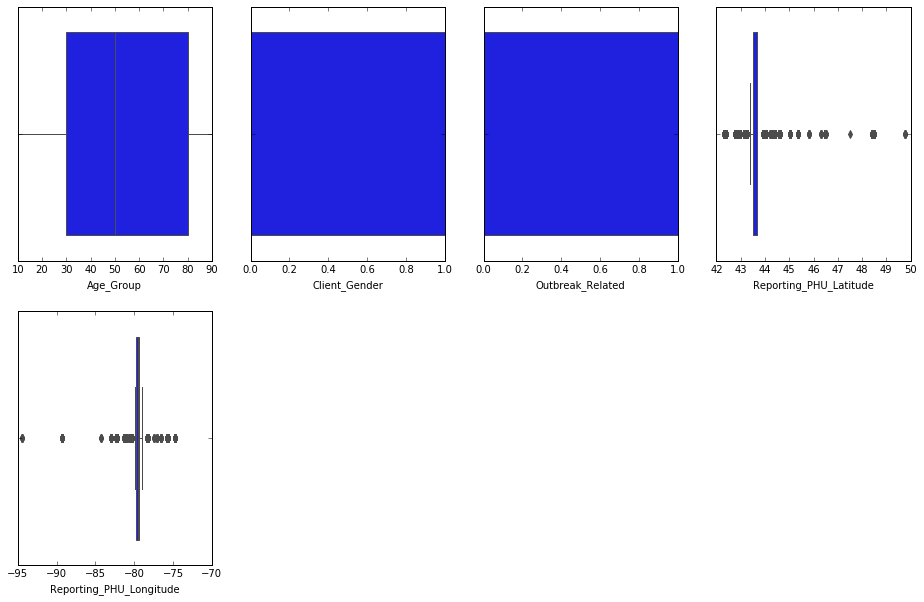

In [23]:
#Box and whiskers plot for detecting the outliers
plt.figure(figsize=(16,10))

for i in range(len(EDA_numeric_features.columns)):
    plt.subplot(2,4,i + 1)
    sns.boxplot(EDA_numeric_features[EDA_numeric_features.columns[i]])

In [24]:
# Calculating zscore of numeric columns in the dataset
z = np.abs(stats.zscore(EDA_numeric_features))

In [25]:
# Defining threshold for filtering outliers
threshold = 3
#np.where(z>3)

In [26]:
# Filtering outliers retaining only those data points which are below threshold
df_covid_cleaned_0 = df_covid_cleaned_0[(z<3).all(axis=1)]

In [27]:
#Onehot encode function definition
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df=pd.concat([df, dummies], axis=1)
        df=df.drop(column, axis=1)
    return df

In [28]:
#Onehot encoding of COVID data
df_covid_cleaned = df_covid_cleaned_0
#nominal_features = ['Client_Gender', 'Case_AcquisitionInfo', 'Reporting_PHU_City']
nominal_features = ['Case_AcquisitionInfo', 'Reporting_PHU_City']
df_covid_cleaned = onehot_encode(df_covid_cleaned, dict(zip(nominal_features, ['CA', 'RC'])))
df_covid_cleaned.head()

Accurate_Episode_Date Case_Reported_Date  Age_Group  Client_Gender  \
0            2020-03-30         2020-03-31         70              1   
1            2021-01-22         2021-01-24         50              0   
2            2020-03-24         2020-04-14         70              0   
3            2021-01-18         2021-01-21         10              1   
4            2020-12-26         2020-12-28         60              1   

   Outbreak_Related  Reporting_PHU_Latitude  Reporting_PHU_Longitude  \
0                 1               43.368662               -81.001913   
1                 0               44.048023               -79.480239   
2                 1               43.656591               -79.379358   
3                 0               43.647471               -79.708893   
4                 1               42.308796               -83.033670   

   Outcome1  CA_CC  CA_MISSING INFORMATION  ...  RC_Point Edward  \
0         2      0                       0  ...                0   
1         1      0                       0  ...                0   
2         0      0                       0  ...                0   
3         1      1                       0  ...                0   
4         0      0                       0  ...                0   

   RC_Port Hope  RC_Simcoe  RC_St. Thomas  RC_Stratford  RC_Thorold  \
0             0          0              0             1           0   
1             0          0              0             0           0   
2             0          0              0             0           0   
3             0          0              0             0           0   
4             0          0              0             0           0   

   RC_Toronto  RC_Waterloo  RC_Whitby  RC_Windsor  
0           0            0          0           0  
1           0            0          0           0  
2           1            0          0           0  
3           0            0          0           0  
4           0            0          0           1  

[5 rows x 40 columns]

In [29]:
#Display number of samples in each class 0-->Resolved, 1-->Not Resolved, 2-->Fatal
df_covid_cleaned['Outcome1'].value_counts()

0    4853
1    4790
2    4769
Name: Outcome1, dtype: int64

In [30]:
df_covid_cleaned#.to_csv('covid_cleaned_2.csv')

Accurate_Episode_Date Case_Reported_Date  Age_Group  Client_Gender  \
0                2020-03-30         2020-03-31         70              1   
1                2021-01-22         2021-01-24         50              0   
2                2020-03-24         2020-04-14         70              0   
3                2021-01-18         2021-01-21         10              1   
4                2020-12-26         2020-12-28         60              1   
...                     ...                ...        ...            ...   
14854            2020-04-05         2020-04-05         50              0   
14855            2020-04-02         2020-04-03         90              0   
14856            2021-01-25         2021-01-26         10              1   
14857            2020-12-07         2020-12-08         40              0   
14859            2021-01-20         2021-01-27         10              1   

       Outbreak_Related  Reporting_PHU_Latitude  Reporting_PHU_Longitude  \
0                     1               43.368662               -81.001913   
1                     0               44.048023               -79.480239   
2                     1               43.656591               -79.379358   
3                     0               43.647471               -79.708893   
4                     1               42.308796               -83.033670   
...                 ...                     ...                      ...   
14854                 1               42.777804               -81.151156   
14855                 0               43.898605               -78.940341   
14856                 0               43.116537               -79.241220   
14857                 0               43.647471               -79.708893   
14859                 0               43.647471               -79.708893   

       Outcome1  CA_CC  CA_MISSING INFORMATION  ...  RC_Point Edward  \
0             2      0                       0  ...                0   
1             1      0                       0  ...                0   
2             0      0                       0  ...                0   
3             1      1                       0  ...                0   
4             0      0                       0  ...                0   
...         ...    ...                     ...  ...              ...   
14854         0      0                       0  ...                0   
14855         2      0                       0  ...                0   
14856         1      1                       0  ...                0   
14857         0      1                       0  ...                0   
14859         1      1                       0  ...                0   

       RC_Port Hope  RC_Simcoe  RC_St. Thomas  RC_Stratford  RC_Thorold  \
0                 0          0              0             1           0   
1                 0          0              0             0           0   
2                 0          0              0             0           0   
3                 0          0              0             0           0   
4                 0          0              0             0           0   
...             ...        ...            ...           ...         ...   
14854             0          0              1             0           0   
14855             0          0              0             0           0   
14856             0          0              0             0           1   
14857             0          0              0             0           0   
14859             0          0              0             0           0   

       RC_Toronto  RC_Waterloo  RC_Whitby  RC_Windsor  
0               0            0          0           0  
1               0            0          0           0  
2               1            0          0           0  
3               0            0          0           0  
4               0            0          0           1  
...           ...          ...        ...         ...  
14854           0     

## Design of the neural network & Implementation

**Network architecture:** First, we choose the fully connected neural network. The architecture is shown in the figure below. Details about the architecture are discussed below as well. \
**Design choice & Number of parameters:** Here we have 37 features aside from the date format features. So the input layer has 37 nodes/neurons. Also, we have 3 lables for our target (Resolved:0, Not Resolved:1, Fatal:2), thus for the output layer we have 3 nodes representing each label. For hidden layers, after referring to online resources https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ and https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw, the number of nodes in the hidden layer is around 2/3 of the input features, and the number of nodes usually decreases as we go for more hidden layers. Besides, for datasets that are not complicated enough, 1 or 2 hidden layers is often enough, and too many layers will cause the problem of overfitting. Based on these, we design 2 hidden layers after the input layer, and the number of nodes/neurons is 24, 12 respectively. \
**Optimizer:** Some optimizers: Adam, SGD, L-BFGS, etc. In our case, we employ Grid Search method to find the optimal optimizers and the according optimal learning rates. Finally, we choose the Adam optimizer with learning rate=0.01. \
**Activation function:** There are many activation functions to choose from: sigmoid, softmax, ReLU, tanh, threshold, gaussian, etc. Given the fact that ReLU do not saturate as easily as sigmoid, and ReLU is now usually the standard activation function to use, we use ReLU as an initial trial. But later Grid Search is used as well to find the best activation function in this case is softsign (for input layer and hidden layers). For the output layer, since it is a multi-classification problem, sigmoid and softmax are considered and compared. \
**Regularization method:** Drop out rate is considered using Grid Search method - the result indicates that we should not drop out any nodes in the model training process (optimal drop out rate=0). L2 Regularization is considered as well. \
**Implementation details:** Grid Search is used to explore the number of epochs and batch size - the optimal number of epochs is 100, and the optimal batch size is 60. \
**Other architecture:** To further explore the dataset, LSTM is used to see whether the performance will improve. (RNN tends to have the problem of vanishing gradient so only LSTM is considered here)

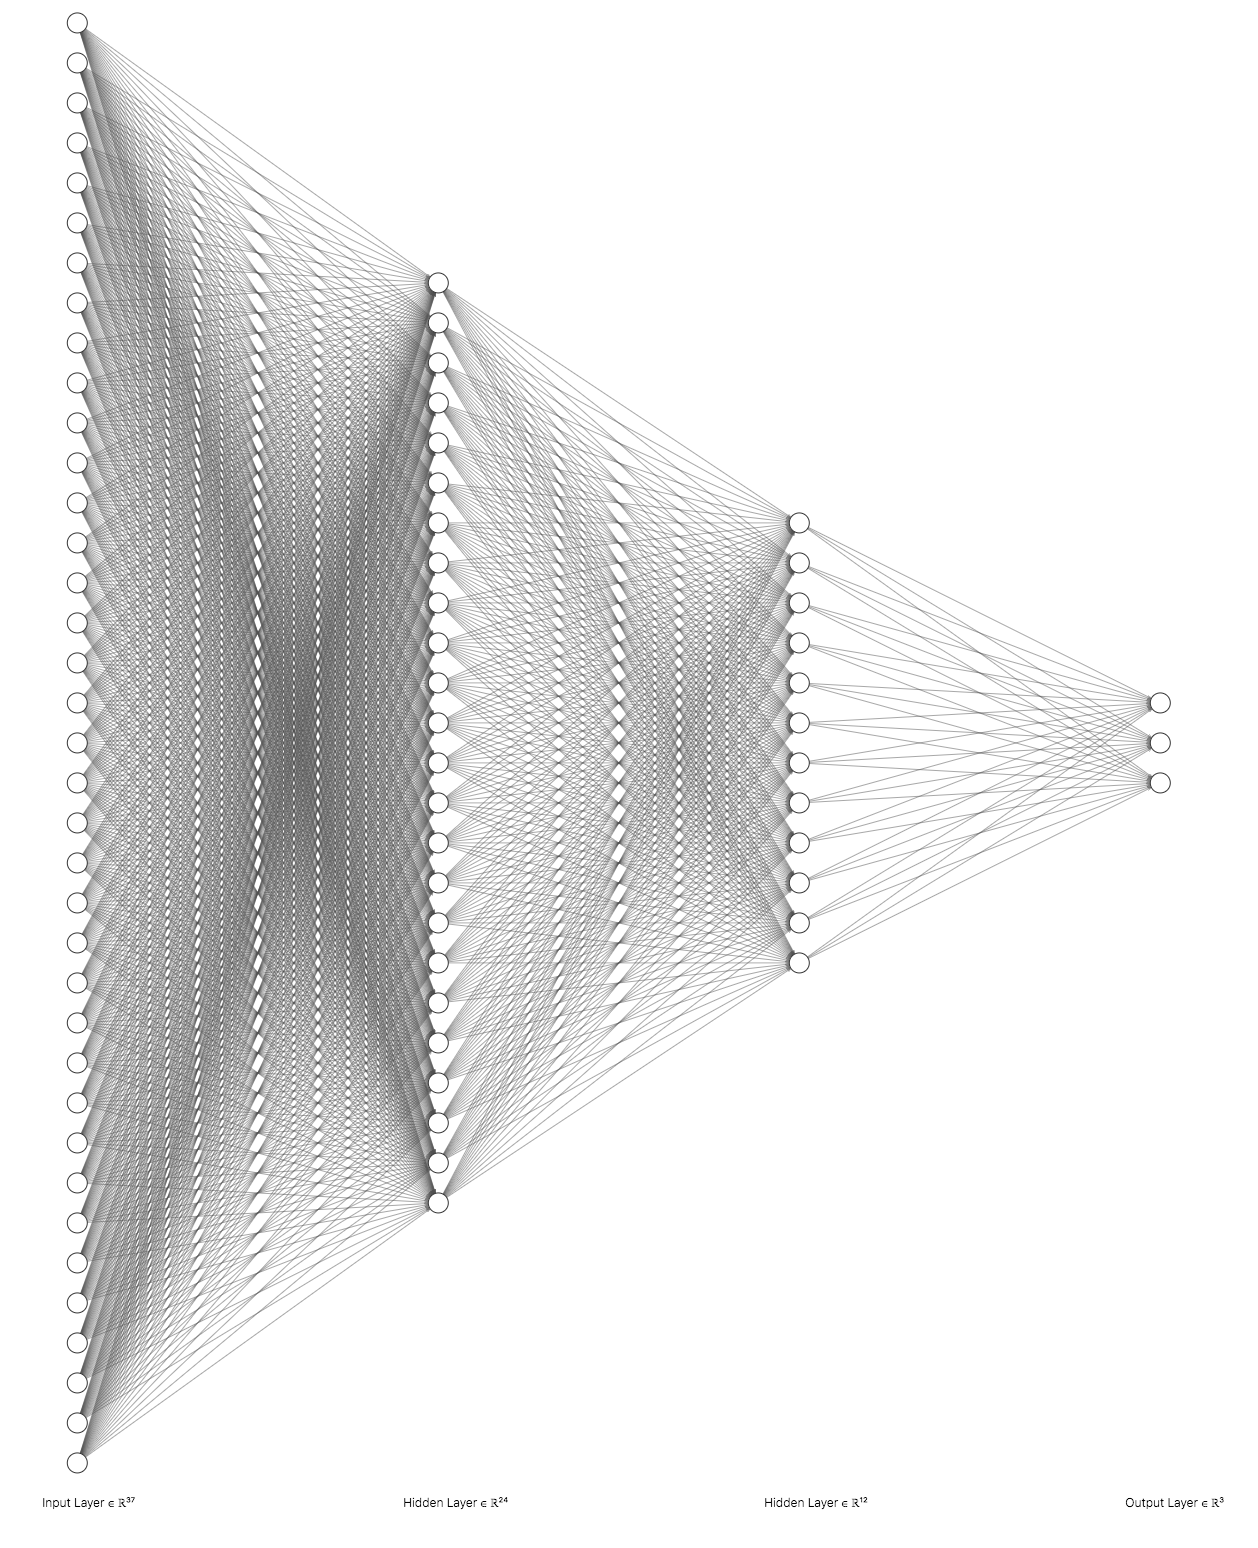

In [378]:
from PIL import Image
# Read image
img = Image.open('original_model.png')
img

In [31]:
df_sub = df_covid_cleaned.drop(['Accurate_Episode_Date','Case_Reported_Date'],axis=1)

In [34]:
#Split the data into train, validation and test sets
X = df_sub.drop('Outcome1',axis=1,inplace=False)
y = df_sub['Outcome1']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)


y_train = keras.utils.to_categorical(y_train, 3)
y_val = keras.utils.to_categorical(y_val, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [35]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

**Grid Search to find optimal batch size and number of epoch**

In [36]:
import numpy
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(24, input_dim=37, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [42]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_val, y_val)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.660770 using {'batch_size': 60, 'epochs': 100}
0.445023 (0.097008) with: {'batch_size': 10, 'epochs': 10}
0.641346 (0.018150) with: {'batch_size': 10, 'epochs': 50}
0.653486 (0.008870) with: {'batch_size': 10, 'epochs': 100}
0.624696 (0.012726) with: {'batch_size': 20, 'epochs': 10}
0.466528 (0.134511) with: {'batch_size': 20, 'epochs': 50}
0.544225 (0.150113) with: {'batch_size': 20, 'epochs': 100}
0.614638 (0.020397) with: {'batch_size': 40, 'epochs': 10}
0.319112 (0.013226) with: {'batch_size': 40, 'epochs': 50}
0.633021 (0.025859) with: {'batch_size': 40, 'epochs': 100}
0.418314 (0.158586) with: {'batch_size': 60, 'epochs': 10}
0.654180 (0.014626) with: {'batch_size': 60, 'epochs': 50}
0.660770 (0.005168) with: {'batch_size': 60, 'epochs': 100}
0.424211 (0.121382) with: {'batch_size': 80, 'epochs': 10}
0.552896 (0.087369) with: {'batch_size': 80, 'epochs': 50}
0.446063 (0.147627) with: {'batch_size': 80, 'epochs': 100}
0.398196 (0.208765) with: {'batch_size': 100, 'epochs':

**Grid Search to find optimal optimizer**

In [37]:
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(24, input_dim=37, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [38]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_val, y_val)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.556712 using {'optimizer': 'Adam'}
0.429761 (0.121575) with: {'optimizer': 'SGD'}
0.527229 (0.140440) with: {'optimizer': 'RMSprop'}
0.367673 (0.209266) with: {'optimizer': 'Adagrad'}
0.325702 (0.026530) with: {'optimizer': 'Adadelta'}
0.556712 (0.144954) with: {'optimizer': 'Adam'}
0.535553 (0.129625) with: {'optimizer': 'Adamax'}
0.537634 (0.145583) with: {'optimizer': 'Nadam'}


**Grid Search to find optimal parameters for optimizer**

In [39]:
def create_model(learn_rate=0.01):
# create model
    model = Sequential()
    model.add(Dense(24, input_dim=37, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    # Compile model
    optimizer = Adam(lr=learn_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [40]:
from keras.optimizers import Adam
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_val, y_val)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.421436 using {'learn_rate': 0.01}
0.390912 (0.082709) with: {'learn_rate': 0.001}
0.421436 (0.136989) with: {'learn_rate': 0.01}
0.333680 (0.014072) with: {'learn_rate': 0.1}
0.331252 (0.011056) with: {'learn_rate': 0.2}
0.337843 (0.009847) with: {'learn_rate': 0.3}


**Grid Search to find optimal activation function**

In [41]:
def create_model(activation='relu'):
# create model
    model = Sequential()
    model.add(Dense(24, input_dim=37, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='sigmoid'))
    # Compile model
    optimizer = Adam(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [42]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_val, y_val)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.608741 using {'activation': 'softsign'}
0.524801 (0.121656) with: {'activation': 'softmax'}
0.507111 (0.134275) with: {'activation': 'softplus'}
0.608741 (0.008496) with: {'activation': 'softsign'}
0.505029 (0.132175) with: {'activation': 'relu'}
0.519251 (0.123627) with: {'activation': 'tanh'}
0.606660 (0.012829) with: {'activation': 'sigmoid'}
0.606660 (0.005571) with: {'activation': 'hard_sigmoid'}
0.337843 (0.009847) with: {'activation': 'linear'}


**Grid Search to find optimal drop out rate (regularization)**

In [43]:
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
#from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0):
    # create model
    model = Sequential()
    model.add(Dense(24, input_dim=37, activation='softsign'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12, activation='softsign'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='sigmoid'))
    # Compile model
    optimizer = Adam(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [44]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)
# define the grid search parameters
#weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_val, y_val)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.616719 using {'dropout_rate': 0.0}
0.616719 (0.007125) with: {'dropout_rate': 0.0}
0.592785 (0.016657) with: {'dropout_rate': 0.1}
0.609088 (0.008595) with: {'dropout_rate': 0.2}
0.610128 (0.007894) with: {'dropout_rate': 0.3}
0.608047 (0.001962) with: {'dropout_rate': 0.4}
0.605272 (0.001962) with: {'dropout_rate': 0.5}
0.611169 (0.001298) with: {'dropout_rate': 0.6}
0.594520 (0.013172) with: {'dropout_rate': 0.7}
0.605619 (0.005306) with: {'dropout_rate': 0.8}
0.470690 (0.122654) with: {'dropout_rate': 0.9}


## Model training

In [198]:
model = Sequential()
model.add(Dense(24, input_dim=37, activation='softsign'))
model.add(Dropout(0.0))
model.add(Dense(12, activation='softsign'))
model.add(Dropout(0.0))
model.add(Dense(3, activation='sigmoid'))
optimizer = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [202]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 24)                912       
_________________________________________________________________
dropout_65 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 12)                300       
_________________________________________________________________
dropout_66 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 3)                 39        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [200]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=100, batch_size=60,validation_data=(X_val, y_val))

Epoch 1/100
145/145 [==============================] - 0s 3ms/step - loss: 0.7884 - accuracy: 0.5872 - val_loss: 0.7355 - val_accuracy: 0.6136
Epoch 2/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7472 - accuracy: 0.6035 - val_loss: 0.7634 - val_accuracy: 0.5879
Epoch 3/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7479 - accuracy: 0.6009 - val_loss: 0.7443 - val_accuracy: 0.6112
Epoch 4/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7453 - accuracy: 0.6043 - val_loss: 0.7763 - val_accuracy: 0.5709
Epoch 5/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7497 - accuracy: 0.6000 - val_loss: 0.7644 - val_accuracy: 0.5834
Epoch 6/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7409 - accuracy: 0.6062 - val_loss: 0.7377 - val_accuracy: 0.5893
Epoch 7/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7434 - accuracy: 0.5996 - val_loss: 0.7620 - val_accuracy: 0.5779

Epoch 58/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7261 - accuracy: 0.6434 - val_loss: 0.7425 - val_accuracy: 0.6157
Epoch 59/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7285 - accuracy: 0.6349 - val_loss: 0.7212 - val_accuracy: 0.6483
Epoch 60/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7255 - accuracy: 0.6445 - val_loss: 0.7278 - val_accuracy: 0.6386
Epoch 61/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7307 - accuracy: 0.6359 - val_loss: 0.7214 - val_accuracy: 0.6344
Epoch 62/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7269 - accuracy: 0.6421 - val_loss: 0.7385 - val_accuracy: 0.6521
Epoch 63/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7327 - accuracy: 0.6388 - val_loss: 0.7275 - val_accuracy: 0.6372
Epoch 64/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7299 - accuracy: 0.6463 - val_loss: 0.7576 - val_accuracy:

In [201]:
# evaluate the keras model
_, accuracy_train = model.evaluate(X_train, y_train)
_, accuracy_test = model.evaluate(X_test, y_test)
print('Training Accuracy: %.2f' % (accuracy_train*100))
print('Test Accuracy: %.2f' % (accuracy_test*100))

91/91 [==============================] - 3s 32ms/step - loss: 0.7291 - accuracy: 0.6545
Training Accuracy: 66.54
Test Accuracy: 65.45


**For the above fully-connected neural network, the training accuracy is 66.54% while the test accuracy is 65.45%.**

## Further experiments
**1.Add L2 regularizer**

In [203]:
model_l2 = Sequential()
model_l2.add(Dense(24, input_dim=37, activation='softsign',activity_regularizer=regularizers.l2(1e-5)))
model_l2.add(Dropout(0.0))
model_l2.add(Dense(12, activation='softsign',activity_regularizer=regularizers.l2(1e-5)))
model_l2.add(Dropout(0.0))
model_l2.add(Dense(3, activation='sigmoid'))
optimizer = Adam(lr=0.01)
model_l2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [204]:
# fit the keras model on the dataset
model_l2.fit(X_train, y_train, epochs=100, batch_size=60,validation_data=(X_val, y_val))

Epoch 1/100
145/145 [==============================] - 0s 3ms/step - loss: 0.7806 - accuracy: 0.5841 - val_loss: 0.7372 - val_accuracy: 0.5997
Epoch 2/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7523 - accuracy: 0.6012 - val_loss: 0.7451 - val_accuracy: 0.6115
Epoch 3/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7458 - accuracy: 0.5994 - val_loss: 0.7358 - val_accuracy: 0.6039
Epoch 4/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7440 - accuracy: 0.6034 - val_loss: 0.7682 - val_accuracy: 0.5893
Epoch 5/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7458 - accuracy: 0.6048 - val_loss: 0.7315 - val_accuracy: 0.6112
Epoch 6/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7443 - accuracy: 0.6041 - val_loss: 0.7269 - val_accuracy: 0.6046
Epoch 7/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7446 - accuracy: 0.5984 - val_loss: 0.7261 - val_accuracy: 0.6143

Epoch 58/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7371 - accuracy: 0.6055 - val_loss: 0.7314 - val_accuracy: 0.6091
Epoch 59/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7335 - accuracy: 0.6136 - val_loss: 0.7245 - val_accuracy: 0.6143
Epoch 60/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7367 - accuracy: 0.6118 - val_loss: 0.7671 - val_accuracy: 0.5838
Epoch 61/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7345 - accuracy: 0.6076 - val_loss: 0.7242 - val_accuracy: 0.6164
Epoch 62/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7336 - accuracy: 0.6186 - val_loss: 0.7335 - val_accuracy: 0.6091
Epoch 63/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7311 - accuracy: 0.6093 - val_loss: 0.7281 - val_accuracy: 0.6070
Epoch 64/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7349 - accuracy: 0.6191 - val_loss: 0.7208 - val_accuracy:

In [205]:
# evaluate the keras model
_, accuracy_train = model_l2.evaluate(X_train, y_train)
_, accuracy_test = model_l2.evaluate(X_test, y_test)
print('Training Accuracy: %.2f' % (accuracy_train*100))
print('Test Accuracy: %.2f' % (accuracy_test*100))

91/91 [==============================] - 0s 754us/step - loss: 0.7366 - accuracy: 0.6448
Training Accuracy: 65.91
Test Accuracy: 64.48


**Both the training and test accuracy are a bit lower than the original model. So we stick to the original model.\
\
2.Change activation function for the output layer (from sigmoid to softmax)**

In [61]:
model_softmax = Sequential()
model_softmax.add(Dense(24, input_dim=37, activation='softsign'))
model_softmax.add(Dropout(0.0))
model_softmax.add(Dense(12, activation='softsign',))
model_softmax.add(Dropout(0.0))
model_softmax.add(Dense(3, activation='softmax'))
optimizer = Adam(lr=0.01)
model_softmax.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [62]:
# fit the keras model on the dataset
model_softmax.fit(X_train, y_train, epochs=100, batch_size=60,validation_data=(X_val, y_val))

Epoch 1/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7874 - accuracy: 0.5907 - val_loss: 0.7550 - val_accuracy: 0.5931
Epoch 2/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7532 - accuracy: 0.6019 - val_loss: 0.7268 - val_accuracy: 0.6136
Epoch 3/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7460 - accuracy: 0.6032 - val_loss: 0.7396 - val_accuracy: 0.6146
Epoch 4/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7510 - accuracy: 0.6005 - val_loss: 0.7484 - val_accuracy: 0.5966
Epoch 5/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7527 - accuracy: 0.5983 - val_loss: 0.7575 - val_accuracy: 0.6025
Epoch 6/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7408 - accuracy: 0.6130 - val_loss: 0.7435 - val_accuracy: 0.6112
Epoch 7/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7417 - accuracy: 0.6227 - val_loss: 0.7332 - val_accuracy: 0.6302

Epoch 58/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7173 - accuracy: 0.6596 - val_loss: 0.7228 - val_accuracy: 0.6504
Epoch 59/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7073 - accuracy: 0.6678 - val_loss: 0.7103 - val_accuracy: 0.6601
Epoch 60/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7108 - accuracy: 0.6652 - val_loss: 0.7058 - val_accuracy: 0.6667
Epoch 61/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7120 - accuracy: 0.6641 - val_loss: 0.7071 - val_accuracy: 0.6604
Epoch 62/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7089 - accuracy: 0.6620 - val_loss: 0.7122 - val_accuracy: 0.6663
Epoch 63/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7138 - accuracy: 0.6632 - val_loss: 0.7307 - val_accuracy: 0.6629
Epoch 64/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7154 - accuracy: 0.6594 - val_loss: 0.7157 - val_accuracy:

In [63]:
# evaluate the keras model
_, accuracy_train = model_softmax.evaluate(X_train, y_train)
_, accuracy_test = model_softmax.evaluate(X_test, y_test)
print('Training Accuracy: %.2f' % (accuracy_train*100))
print('Test Accuracy: %.2f' % (accuracy_test*100))

91/91 [==============================] - 0s 563us/step - loss: 0.7439 - accuracy: 0.6271
Training Accuracy: 64.04
Test Accuracy: 62.71


**Both the training and test accuracy are lower than the original model using 'sigmoid' for the output layer.\
\
3.Add more layers/neurons to make the model more complicated**

In [64]:
model_comp = Sequential()
model_comp.add(Dense(24, input_dim=37, activation='softsign'))
model_comp.add(Dropout(0.0))
model_comp.add(Dense(16, activation='softsign'))
model_comp.add(Dropout(0.0))
model_comp.add(Dense(10, activation='softsign'))
model_comp.add(Dropout(0.0))
model_comp.add(Dense(3, activation='sigmoid'))
optimizer = Adam(lr=0.01)
model_comp.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

**The new architecture is shown below:**

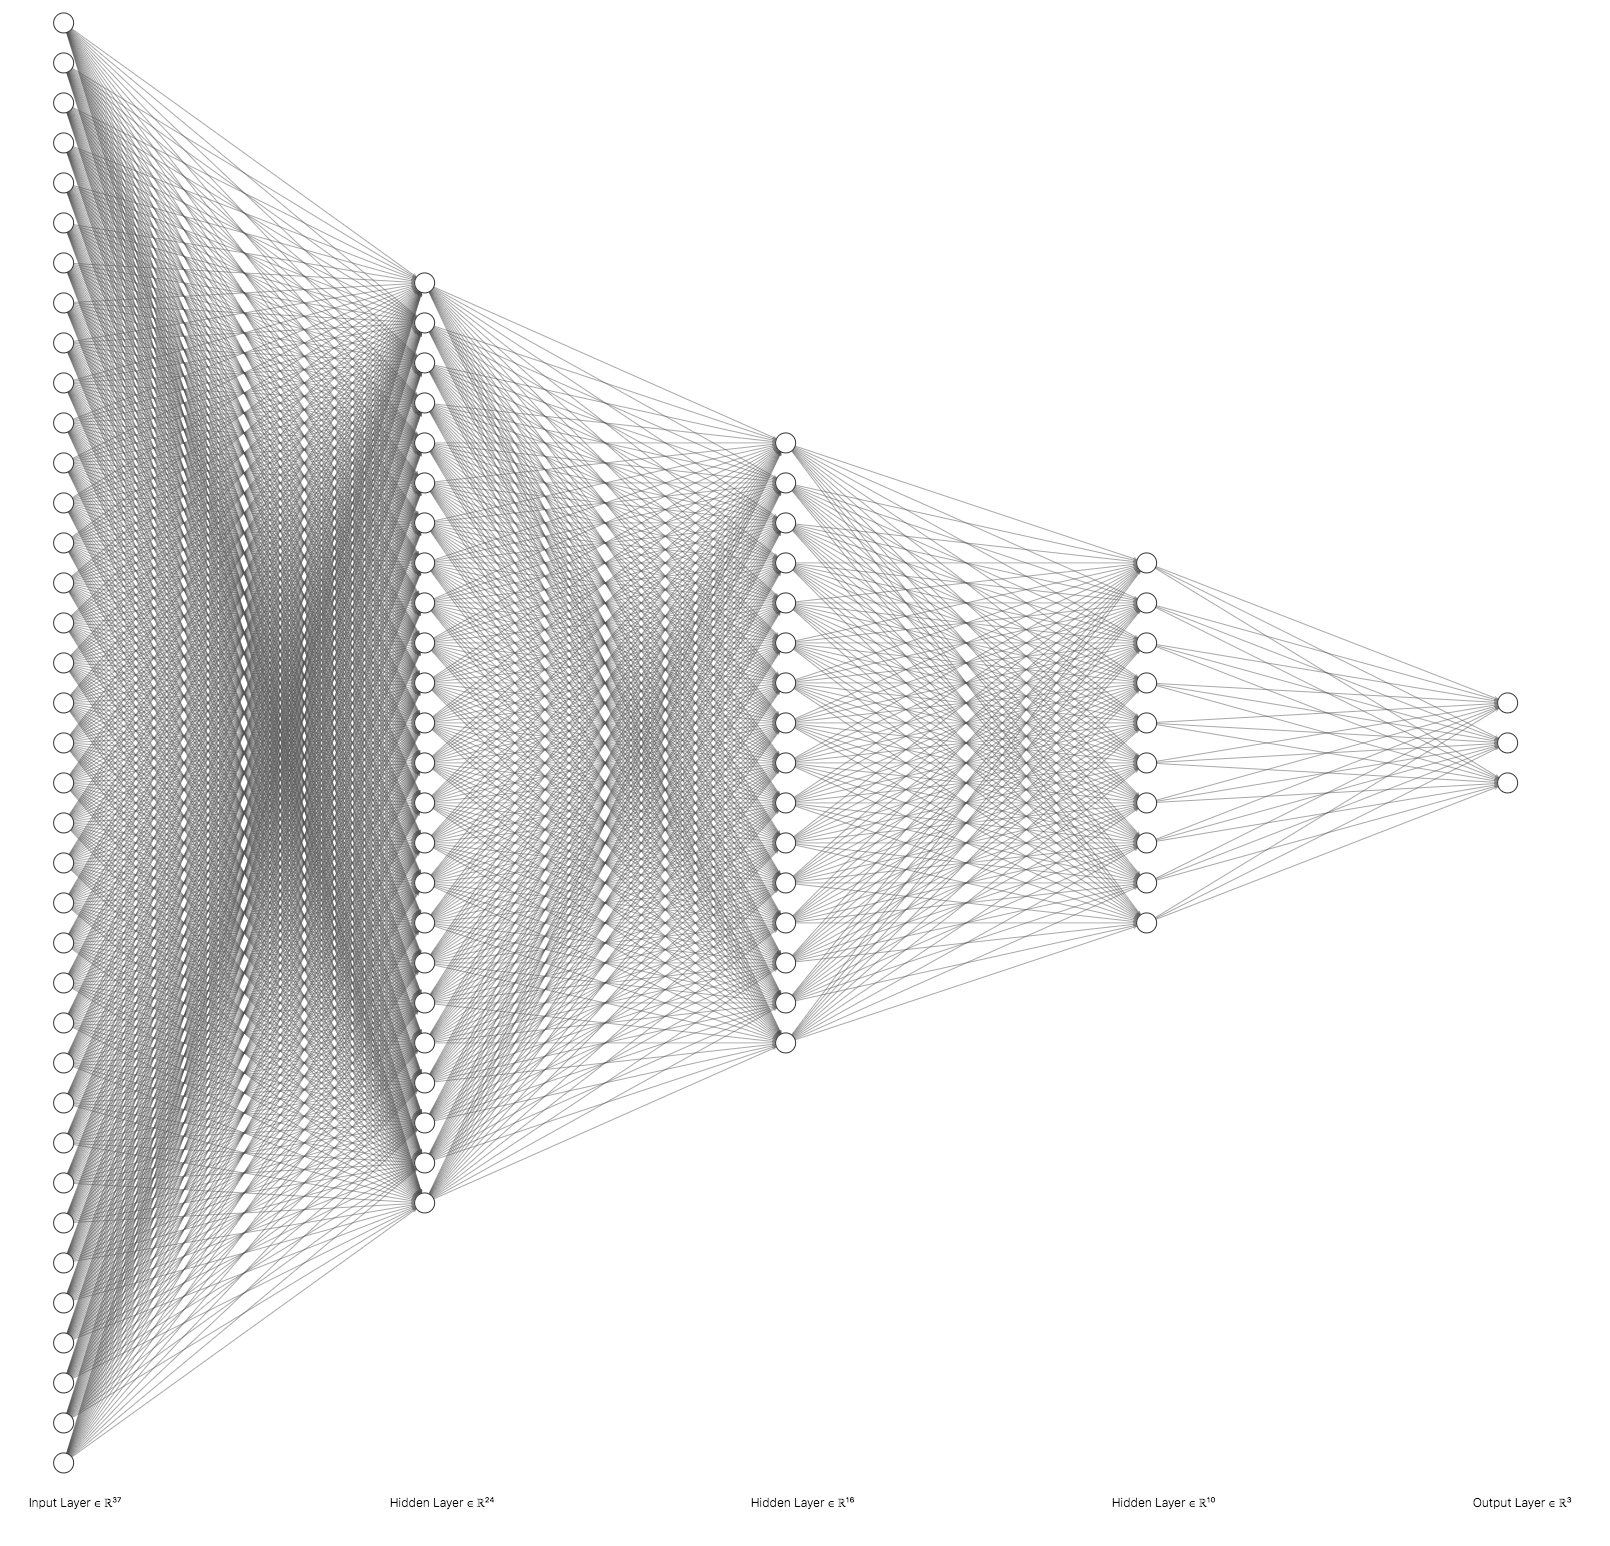

In [381]:
from PIL import Image
# Read image
img = Image.open('more_layers.png')
img

In [357]:
# fit the keras model on the dataset
model_comp.fit(X_train, y_train, epochs=100, batch_size=60,validation_data=(X_val, y_val))

Epoch 1/100
145/145 [==============================] - 2s 16ms/step - loss: 0.7552 - accuracy: 0.6026 - val_loss: 0.7363 - val_accuracy: 0.6039
Epoch 2/100
145/145 [==============================] - 2s 16ms/step - loss: 0.7385 - accuracy: 0.6042 - val_loss: 0.7323 - val_accuracy: 0.6098
Epoch 3/100
145/145 [==============================] - 2s 15ms/step - loss: 0.7379 - accuracy: 0.6028 - val_loss: 0.7315 - val_accuracy: 0.6077
Epoch 4/100
145/145 [==============================] - 2s 16ms/step - loss: 0.7379 - accuracy: 0.6034 - val_loss: 0.7316 - val_accuracy: 0.6105
Epoch 5/100
145/145 [==============================] - 2s 16ms/step - loss: 0.7368 - accuracy: 0.6026 - val_loss: 0.7306 - val_accuracy: 0.6122
Epoch 6/100
145/145 [==============================] - 2s 16ms/step - loss: 0.7363 - accuracy: 0.6051 - val_loss: 0.7299 - val_accuracy: 0.6126
Epoch 7/100
145/145 [==============================] - 2s 16ms/step - loss: 0.7356 - accuracy: 0.6068 - val_loss: 0.7379 - val_accuracy:

In [358]:
# evaluate the keras model
_, accuracy_train = model_comp.evaluate(X_train, y_train)
_, accuracy_test = model_comp.evaluate(X_test, y_test)
print('Training Accuracy: %.2f' % (accuracy_train*100))
print('Test Accuracy: %.2f' % (accuracy_test*100))

91/91 [==============================] - 0s 755us/step - loss: 0.7584 - accuracy: 0.5713
Training Accuracy: 59.25
Test Accuracy: 57.13


**Adding another layer and increasing the number of neurons lead to a large drop in training and test accuracy. One possible reason is that by adding more layers, the structure of the neural network changes, and grid search should be used again to find the optimal parameters. For simplicity, we stick to the original model which reaches a higher performance.\
\
Besides, for this neural network with 2 hidden layers, vanishing gradient is not a serious issue. So Resnet is not necessary in this case.\
\
4.Take time into consideration - LSTM\
(The general RNN tends to have the problem of vanishing gradient, so LSTM is used here)**

In [280]:
df_time = df_covid_cleaned.drop('Accurate_Episode_Date',axis=1).sort_values('Case_Reported_Date',ascending=True)
df_time = df_time.set_index('Case_Reported_Date')

In [281]:
df_time

Age_Group  Client_Gender  Outbreak_Related  \
Case_Reported_Date                                               
2020-03-08                 80              0                 1   
2020-03-09                 50              1                 0   
2020-03-12                 20              1                 0   
2020-03-12                 60              0                 1   
2020-03-13                 70              1                 0   
...                       ...            ...               ...   
2021-01-30                 30              1                 0   
2021-01-30                 60              1                 0   
2021-01-30                 40              1                 0   
2021-01-30                 40              0                 0   
2021-01-30                 80              0                 0   

                    Reporting_PHU_Latitude  Reporting_PHU_Longitude  Outcome1  \
Case_Reported_Date                                                              
2020-03-08                       43.656591               -79.379358         2   
2020-03-09                       44.048023               -79.480239         0   
2020-03-12                       43.656591               -79.379358         0   
2020-03-12                       43.656591               -79.379358         0   
2020-03-13                       43.656591               -79.379358         2   
...                                    ...                      ...       ...   
2021-01-30                       43.656591               -79.379358         1   
2021-01-30                       43.647471               -79.708893         1   
2021-01-30                       44.048023               -79.480239         1   
2021-01-30                       43.647471               -79.708893         1   
2021-01-30                       43.898605               -78.940341         1   

                    CA_CC  CA_MISSING INFORMATION  CA_NO KNOWN EPI LINK  \
Case_Reported_Date                                                        
2020-03-08              0                       0                     0   
2020-03-09              0                       0                     0   
2020-03-12              0                       0                     0   
2020-03-12              0                       0                     0   
2020-03-13              0                       0                     0   
...                   ...                     ...                   ...   
2021-01-30              0                       1                     0   
2021-01-30              0                       1                     0   
2021-01-30              0                       1                     0   
2021-01-30              0                       0                     1   
2021-01-30              0                       1                     0   

                    CA_OB  ...  RC_Point Edward  RC_Port Hope  RC_Simcoe  \
Case_Reported_Date         ...                                             
2020-03-08              1  ...                0             0          0   
2020-03-09              0  ...                0             0          0   
2020-03-12              0  ...                0             0          0   
2020-03-12              0  ...                0             0          0   
2020-03-13              0  ...                0             0          0   
...                   ...  ...              ...           ...        ...   
2021-01-30              0  ...                0             0          0   
2021-01-30              0  ...                0             0          0   
2021-01-30              0  ...                0             0          0   
2021-01-30              0  ...                0             0          0   
2021-01-30              0  ...                0             0          0   

                    RC_St. Thomas  RC_Stratford  RC_Thorold  RC_Toronto  \
Case_Reported_Date                                                 

**For LSTM, the order of data points is important, so train-test split should be done in an orderly way rather than random. Besides, min-maximization is used to scale the data, which is a common pre-requisite for training LSTM. To implement LSTM, the batch size should be put to 1 as each case is built on the previous one.**

In [371]:
#Split the data into train, validation and test sets
X_t = df_time.drop('Outcome1',axis=1,inplace=False)
y_t = df_time['Outcome1']

X_train_t = X_t[:8647]
X_val_t = X_t[8647:11530]
X_test_t = X_t[11530:]
y_train_t = y_t[:8647]
y_val_t = y_t[8647:11530]
y_test_t = y_t[11530:]

y_train_t = keras.utils.to_categorical(y_train_t, 3)
y_val_t = keras.utils.to_categorical(y_val_t, 3)
y_test_t = keras.utils.to_categorical(y_test_t, 3)

In [372]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_t = scaler.fit_transform(X_train_t)
X_val_t = scaler.fit_transform(X_val_t)
X_test_t = scaler.fit_transform(X_test_t)
y_train_t = scaler.fit_transform(y_train_t)
y_val_t = scaler.fit_transform(y_val_t)
y_test_t = scaler.fit_transform(y_test_t)

In [373]:
#1 timestamp, 37 features
X_train_t=X_train_t.reshape(X_train_t.shape[0],1,X_train_t.shape[1])
X_val_t=X_val_t.reshape(X_val_t.shape[0],1,X_val_t.shape[1])
X_test_t=X_test_t.reshape(X_test_t.shape[0],1,X_test_t.shape[1])

In [374]:
model_t = Sequential()
model_t.add(LSTM(units = 24, return_sequences = True, input_shape = (1,37),activation='softsign'))
model_t.add(Dropout(0.2))
model_t.add(LSTM(12, activation='softsign'))
model_t.add(Dropout(0.2))
model_t.add(Dense(3, activation='sigmoid'))
optimizer = Adam(lr=0.01)
model_t.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [375]:
# fit the keras model on the dataset
model_t.fit(X_train_t, y_train_t, epochs=10, batch_size=1,validation_data=(X_val_t, y_val_t))

Epoch 1/10
8647/8647 [==============================] - 16s 2ms/step - loss: 0.3742 - accuracy: 0.8580 - val_loss: 4.2205 - val_accuracy: 0.2955
Epoch 2/10
8647/8647 [==============================] - 16s 2ms/step - loss: 0.3286 - accuracy: 0.8817 - val_loss: 4.4813 - val_accuracy: 0.3028
Epoch 3/10
8647/8647 [==============================] - 15s 2ms/step - loss: 0.3257 - accuracy: 0.8818 - val_loss: 5.1671 - val_accuracy: 0.3045
Epoch 4/10
8647/8647 [==============================] - 15s 2ms/step - loss: 0.3220 - accuracy: 0.8840 - val_loss: 5.7661 - val_accuracy: 0.3011
Epoch 5/10
8647/8647 [==============================] - 15s 2ms/step - loss: 0.3205 - accuracy: 0.8848 - val_loss: 5.2538 - val_accuracy: 0.3011
Epoch 6/10
8647/8647 [==============================] - 15s 2ms/step - loss: 0.3174 - accuracy: 0.8861 - val_loss: 5.0653 - val_accuracy: 0.2997
Epoch 7/10
8647/8647 [==============================] - 15s 2ms/step - loss: 0.3125 - accuracy: 0.8860 - val_loss: 5.6523 - val_ac

In [376]:
# evaluate the keras model
_, accuracy_train = model_t.evaluate(X_train_t, y_train_t)
_, accuracy_test = model_t.evaluate(X_test_t, y_test_t)
print('Training Accuracy: %.2f' % (accuracy_train*100))
print('Test Accuracy: %.2f' % (accuracy_test*100))

91/91 [==============================] - 0s 1ms/step - loss: 7.7948 - accuracy: 0.0142
Training Accuracy: 89.78
Test Accuracy: 1.42


**The training accuracy is very high while the test accuracy is extremely low. One reason is that in our situation, there is not a trend between the cases on different dates, and ordering the data based on date does not add any meaning. To be more specific, unlike time series data, a case labelled 'Resolved' today is kind of independent of a case lablled 'Fatal' for tomorrow, as the dataset does not include enough information to show any trend based on time.\
So we should stick to our original model. And the summary of final chosen model is as follow:**

In [217]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 24)                912       
_________________________________________________________________
dropout_65 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 12)                300       
_________________________________________________________________
dropout_66 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 3)                 39        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


# Result Analysis
## Run time performance

In [219]:
%%time
model_run = Sequential()
model_run.add(Dense(24, input_dim=37, activation='softsign'))
model_run.add(Dropout(0.0))
model_run.add(Dense(12, activation='softsign'))
model_run.add(Dropout(0.0))
model_run.add(Dense(3, activation='sigmoid'))
optimizer = Adam(lr=0.01)
model_run.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_run.fit(X_train, y_train, epochs=100, batch_size=60,validation_data=(X_val, y_val))
pred = model_run.predict(X_test)
print(pred)

Epoch 1/100
145/145 [==============================] - 0s 3ms/step - loss: 0.7774 - accuracy: 0.5908 - val_loss: 0.7515 - val_accuracy: 0.5987
Epoch 2/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7458 - accuracy: 0.6014 - val_loss: 0.7316 - val_accuracy: 0.6080
Epoch 3/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7459 - accuracy: 0.5974 - val_loss: 0.7312 - val_accuracy: 0.6119
Epoch 4/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7448 - accuracy: 0.5978 - val_loss: 0.7300 - val_accuracy: 0.6053
Epoch 5/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7467 - accuracy: 0.6026 - val_loss: 0.7256 - val_accuracy: 0.6091
Epoch 6/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7380 - accuracy: 0.6049 - val_loss: 0.7266 - val_accuracy: 0.6115
Epoch 7/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7418 - accuracy: 0.6004 - val_loss: 0.7461 - val_accuracy: 0.6025

Epoch 58/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7367 - accuracy: 0.6209 - val_loss: 0.7871 - val_accuracy: 0.5917
Epoch 59/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7366 - accuracy: 0.6040 - val_loss: 0.7640 - val_accuracy: 0.5813
Epoch 60/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7366 - accuracy: 0.6124 - val_loss: 0.7465 - val_accuracy: 0.6139
Epoch 61/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7351 - accuracy: 0.6199 - val_loss: 0.7256 - val_accuracy: 0.6178
Epoch 62/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7337 - accuracy: 0.6262 - val_loss: 0.7272 - val_accuracy: 0.6178
Epoch 63/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7331 - accuracy: 0.6233 - val_loss: 0.7371 - val_accuracy: 0.6035
Epoch 64/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7344 - accuracy: 0.6261 - val_loss: 0.7348 - val_accuracy:

**Running time:\
CPU times: user 25.6 s, sys: 4 s, total: 29.6 s\
Wall time: 18.3 s**

## Comparison of different algorithms and parameters
**We start with the fully-connected neural network with two hidden layers (first whith 24 nodes, second with 12 nodes). Using Grid Search, the activation function is softsign for hidden layers and sigmoid for the output layer, the optimizer is Adam(learning rate=0.01), the optimal number of epochs and batch size is 100 and 60. Drop out rate should be 0 to achieve the optimum. The training accuracy is 66.54% and test accuracy is 65.45%.\
Next, several modifications are made to the original model to compare the performance. 1) Add L2 regularizer; 2) Change the activation function from sigmoid to softmax in the output layer; 3) Add more layers/neurons; 4) Apply LSTM to the data.\
The training and test accuracy in the above first 3 methods are lower than the original model. For LSTM, it achieves much higher training performance compared with the original model, but performs very bad on unseen data. So we decide to stick to the original model for further analysis.\
The relevant code and more detailed analysis are attached below.**

## Plots

In [234]:
model_run = Sequential()
model_run.add(Dense(24, input_dim=37, activation='softsign'))
model_run.add(Dropout(0.0))
model_run.add(Dense(12, activation='softsign'))
model_run.add(Dropout(0.0))
model_run.add(Dense(3, activation='sigmoid'))
optimizer = Adam(lr=0.01)
model_run.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_run.fit(X_train, y_train, epochs=100, batch_size=60,validation_data=(X_val, y_val))

Epoch 1/100
145/145 [==============================] - 0s 2ms/step - loss: 0.7833 - accuracy: 0.5902 - val_loss: 0.7347 - val_accuracy: 0.6063
Epoch 2/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7562 - accuracy: 0.5925 - val_loss: 0.7390 - val_accuracy: 0.6039
Epoch 3/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7420 - accuracy: 0.5994 - val_loss: 0.7289 - val_accuracy: 0.6115
Epoch 4/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7480 - accuracy: 0.6022 - val_loss: 0.7322 - val_accuracy: 0.6174
Epoch 5/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7404 - accuracy: 0.6021 - val_loss: 0.7414 - val_accuracy: 0.6077
Epoch 6/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7462 - accuracy: 0.6043 - val_loss: 0.7288 - val_accuracy: 0.6101
Epoch 7/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7426 - accuracy: 0.5990 - val_loss: 0.7268 - val_accuracy: 0.6129

Epoch 58/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7349 - accuracy: 0.6026 - val_loss: 0.7438 - val_accuracy: 0.5994
Epoch 59/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7417 - accuracy: 0.5953 - val_loss: 0.7366 - val_accuracy: 0.6035
Epoch 60/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7379 - accuracy: 0.5983 - val_loss: 0.7239 - val_accuracy: 0.6108
Epoch 61/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7303 - accuracy: 0.6007 - val_loss: 0.7275 - val_accuracy: 0.6056
Epoch 62/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7360 - accuracy: 0.5994 - val_loss: 0.7337 - val_accuracy: 0.6025
Epoch 63/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7385 - accuracy: 0.6009 - val_loss: 0.7286 - val_accuracy: 0.6143
Epoch 64/100
145/145 [==============================] - 0s 1ms/step - loss: 0.7365 - accuracy: 0.6007 - val_loss: 0.7248 - val_accuracy:

In [235]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


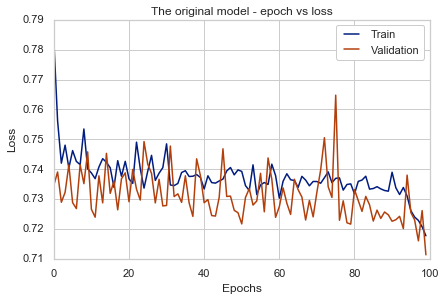

In [236]:
plt.plot(model_run.history.history['loss'])
plt.plot(model_run.history.history['val_loss'])
plt.title("The original model - epoch vs loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

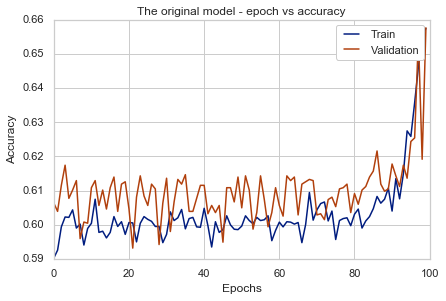

In [237]:
plt.plot(model_run.history.history['accuracy'])
plt.plot(model_run.history.history['val_accuracy'])
plt.title("The original model - epoch vs accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

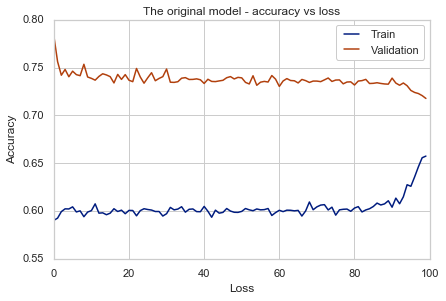

In [239]:
plt.plot(model_run.history.history['accuracy'])
plt.plot(model_run.history.history['loss'])
plt.title("The original model - accuracy vs loss")
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

**From the above set of plots, we can see that as the epoch# increases, the loss decreases and the accuracy improves. And the training curve and validation curve fit well, which means there is no apparent sign of overfitting or underfitting.**

## Evaluation of model
**Confusion matrix is plotted, and the classification report is extracted to see how the trained model performs on unseen data in more detail.**

In [252]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

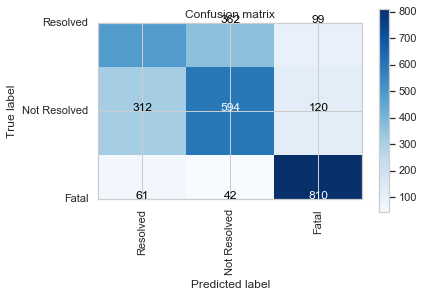

In [256]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['Resolved','Not Resolved','Fatal'])

In [258]:
classes = ['Resolved','Not Resolved','Fatal']
print(classification_report(y_true, y_pred_classes, target_names = classes))

              precision    recall  f1-score   support

    Resolved       0.56      0.51      0.54       944
Not Resolved       0.60      0.58      0.59      1026
       Fatal       0.79      0.89      0.83       913

    accuracy                           0.65      2883
   macro avg       0.65      0.66      0.65      2883
weighted avg       0.65      0.65      0.65      2883



**Based on the above, we can conclude that: 1) the performance of the trained model is overally good, without the problem of overfitting or underfitting; 2) the model is better at identifying 'Fatal' cases, followed by 'Not Resolved' and 'Resolved' cases. 3) the model has higher precision than recall when identifying 'Resolved' cases (less False Positive), has higher recall than precision when identifying 'Fatal' cases (less False Negative).\
This is in line with the expectations in the healthcare industry as we do not want to miss any 'Fatal'/'Unsolved' cases. And healthcare workers may use this model to identify patients at most risk and take early actions accordingly.**

# Reference
[1] https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/ \
[2] https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/ \
[3] https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ \
[4] https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ \
[5] https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw \
[6] https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ \
[7] https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/ \
[8] https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ \
[9] http://alexlenail.me/NN-SVG/index.html